In [1]:
import numpy as np
import torch as pt
from matplotlib import pyplot as plt
import sys
from pathlib import Path
import src.constants as constants
import sys
from display_data.data_acquisition_shadow import derandomized_classical_shadow, randomized_classical_shadow
from display_data.prediction_shadow import estimate_exp
sys.path.append(Path('../src'))
from src.mps import MPS
from src.tfim_hamiltonian_open_fermion import TfimHamiltonianOpenFermion
from src.mps_quantum_state import MPSQuantumState

In [2]:
#generate a random tensor list
qubit_num = 10
bond_dim = 50
tensor_liste = [pt.randn([1, 2, bond_dim], dtype=pt.cdouble)]
for idx in range(qubit_num - 2):
    tensor_liste.append(pt.rand([bond_dim, 2, bond_dim], dtype=pt.cdouble))
tensor_liste.append(pt.rand([bond_dim, 2, 1], dtype=pt.cdouble))

In [2]:
# this function converts the stored measurement outcomes to the correct shape needed for the shadow prediction
def conversion_to_prediction_shadow_dict_shape(measurement_procedure, measurement_index, qubit_num):
    to_str_func = np.vectorize(lambda x: np.binary_repr(x).zfill(qubit_num))
    strs = to_str_func(measurement_index)
    dirac_rep = np.zeros(list(measurement_index.shape) + [qubit_num], dtype=np.int8)
    for bit_ix in range(0, qubit_num):
        fetch_bit_func = np.vectorize(lambda x: x[bit_ix] == '1')
        dirac_rep[...,bit_ix] = fetch_bit_func(strs).astype("int8")
    measurement_array = np.where(dirac_rep == 1, -1, dirac_rep)
    measurement_array = np.where(dirac_rep == 0, 1, measurement_array)
    measurement = np.dstack((measurement_procedure, np.array(measurement_array, dtype=int)))
    return measurement

In [193]:
ratio_h_j = 0.1
qubit_num = 14
save_direc_groundstate = Path('data/Diagonal_hamiltonian/groundstate_dict.npy')
ground_state_dict = np.load(save_direc_groundstate, allow_pickle='TRUE')
ground_state_dict = ground_state_dict.item()
ground_state = ground_state_dict[str(1)]['open'][str(qubit_num)][str(ratio_h_j)]
mps = MPS.from_state_vector(qubit_num, ground_state)
mps.normalise()
mps.canonicalise(qubit_num - 1)

In [194]:
save_direc_eigs = Path('data/Diagonal_hamiltonian/eigenvalues_first_three_dict.npy')
energy_dict = np.load(save_direc_eigs, allow_pickle=True)
energy_dict = energy_dict.item()
energy_brute = energy_dict[str(1)]['open'][str(qubit_num)][str(ratio_h_j)][0]
print(energy_brute)

-13.040028203462525


In [13]:
# now we have a method to keep only the unique indices, now we convert the measurements to the necessary shape for shadow prediction
batches = 5
num_of_measurements = np.array([5, 10, 20, 50, 100, 200])
num_of_measurements_per_rot = np.array([5, 10, 20, 50, 100, 200])
meas_methods = ['randomized, derandomized']
energies_different_meas_num = np.zeros((np.size(num_of_measurements), batches))
mps.normalise()
mps.canonicalise(qubit_num - 1)
for b in range(batches):
    print('starting batch ' + str(b))
    for i in range(np.size(num_of_measurements)):
        observables = TfimHamiltonianOpenFermion(qubit_num, ratio_h_j, 1, 'open').observables_for_energy_estimation()
        meas_outcomes, meas_procedure, probs = MPSQuantumState(qubit_num, mps).measurement_shadow(num_of_measurements[i], num_of_measurements_per_rot[i], 'derandomized', observables)
        energies = pt.zeros(len(meas_outcomes))
        for n in range(len(meas_outcomes)):
            probs_direct = MPSQuantumState(qubit_num, mps).rotate_pauli(meas_procedure[n]).prob(pt.tensor(meas_outcomes[n]))
            measurements = conversion_to_prediction_shadow_dict_shape([meas_procedure[n]]*len(meas_outcomes[n]), np.array(meas_outcomes[n]), qubit_num)
            energies[n] = TfimHamiltonianOpenFermion(qubit_num, ratio_h_j, 1, 'open').energy_shadow_mps_modified(measurements, probs_direct, 'derandomized')
        energy = pt.mean(energies)
        energies_different_meas_num[i,b] = energy

starting batch 0
starting batch 1
starting batch 2
starting batch 3
starting batch 4


Text(0, 0.5, '$\\epsilon$')

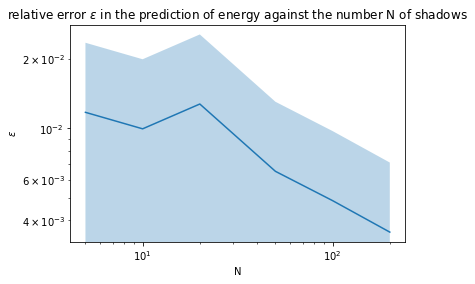

In [15]:
rel_error = np.abs((energies_different_meas_num - energy_brute) / energy_brute)
rel_error_mean = np.mean(rel_error, axis=1)
rel_error_std = np.mean(rel_error, axis=1)
plt.plot(num_of_measurements, rel_error_mean)
plt.fill_between(num_of_measurements, rel_error_mean - rel_error_std, rel_error_mean + rel_error_std, alpha=0.3)
plt.yscale('log')
plt.xscale('log')
plt.title('relative error $\epsilon$ in the prediction of energy against the number N of shadows')
plt.xlabel('N')
plt.ylabel('$\epsilon$')

In [46]:
# now we try to estimate the gradient directly by contracting the mps with hamiltonian
#generate a random tensor list
bond_dim = 50
tensor_liste_rand = [pt.rand([1, 2, bond_dim], dtype=pt.cdouble)]
for idx in range(qubit_num - 2):
    tensor_liste_rand.append(pt.rand([bond_dim, 2, bond_dim], dtype=pt.cdouble))
tensor_liste_rand.append(pt.rand([bond_dim, 2, 1], dtype=pt.cdouble))
mps = MPS.from_tensor_list(tensor_liste_rand).normalise()
mps.canonicalise(qubit_num - 1)
param_vec = mps.to_param_vec()
# we only needed this param vec to determine the size of the tensor
random_param_vec = pt.rand(param_vec.shape[0], dtype=pt.cdouble)

In [47]:
# we estimate the energy exactly by contraction with the hamiltonian
random_param_vec_brute = random_param_vec.detach()
random_param_vec_brute.requires_grad_(True)
mps.from_param_vec(param_vec=random_param_vec_brute)
psi = mps.to_state_vector()
hamiltonian = pt.from_numpy(TfimHamiltonianOpenFermion(qubit_num, ratio_h_j, 1, 'open').to_matrix().todense())
energy_bf = psi.conj() @ hamiltonian @ psi / (psi.conj() @ psi)
print(f'BF E = {energy_bf}')
energy_bf.backward()

BF E = (1.4496784399744183+9.866944387243279e-17j)


In [21]:
# now we estimate the gradient by using the classical shadows
num_of_measurements = np.array([10, 20, 50, 100, 200, 500])
num_of_measurements_per_rot = 200
batches = 5
errors = np.zeros((np.size(num_of_measurements), batches))

for b in range(0, batches):
    for j in range(np.size(num_of_measurements)):
        random_param_vec_shadow = random_param_vec.detach()
        random_param_vec_shadow.requires_grad_(True)
        mps = MPS.from_tensor_list(tensor_liste_rand)
        mps.from_param_vec(param_vec=random_param_vec_shadow)
        mps.normalise()
    #mps.tensors[0] = mps.tensors[0] / mps.norm()
        meas_outcomes, meas_procedure, probs = MPSQuantumState(qubit_num, mps).measurement_shadow(num_of_measurements[j], num_of_measurements_per_rot)
        energies = pt.zeros(len(meas_outcomes))
        for n in range(len(meas_outcomes)):
            probs_direct = MPSQuantumState(qubit_num, mps).rotate_pauli(meas_procedure[n]).prob(pt.tensor(meas_outcomes[n]))
            measurements = conversion_to_prediction_shadow_dict_shape([meas_procedure[n]]*len(meas_outcomes[n]), np.array(meas_outcomes[n]), qubit_num)
            energies[n] = TfimHamiltonianOpenFermion(qubit_num, ratio_h_j, 1, 'open').energy_shadow_mps_modified(measurements, probs_direct)
        energy_shadow = pt.mean(energies)
        print(f'SH E = {energy_shadow}')
        energy_shadow.backward()
        errors[j,b] = pt.linalg.norm((random_param_vec_brute.grad - random_param_vec_shadow.grad)/pt.linalg.norm(random_param_vec_brute.grad))

SH E = 0.595568835735321
SH E = 0.5090430378913879
SH E = 0.5312356352806091
SH E = 0.586112380027771
SH E = 0.6039906144142151
SH E = 0.5812474489212036
SH E = 0.7198468446731567
SH E = 0.7485888004302979
SH E = 0.6199989914894104
SH E = 0.609914243221283
SH E = 0.6088409423828125
SH E = 0.6096405982971191
SH E = 0.6562424302101135
SH E = 0.4891132414340973
SH E = 0.6034649014472961
SH E = 0.6662202477455139
SH E = 0.604587733745575
SH E = 0.6287092566490173
SH E = 0.6680187582969666
SH E = 0.5541718006134033
SH E = 0.624954342842102
SH E = 0.6692126393318176
SH E = 0.5808590054512024
SH E = 0.6157920360565186
SH E = 0.5356894731521606
SH E = 0.647311806678772
SH E = 0.6327542662620544
SH E = 0.5311230421066284
SH E = 0.5685957074165344
SH E = 0.5744816660881042


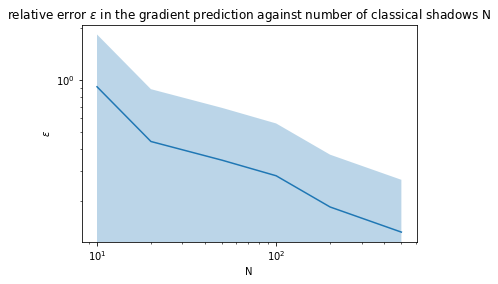

In [22]:
rel_error_mean = np.mean(errors, axis=1)
rel_error_std = np.mean(errors, axis=1)
plt.plot(num_of_measurements, rel_error_mean)
plt.fill_between(num_of_measurements, rel_error_mean - rel_error_std, rel_error_mean + rel_error_std, alpha=0.3)
plt.title('relative error $\epsilon$ in the gradient prediction against number of classical shadows N')
plt.xlabel('N')
plt.ylabel('$\epsilon$')
plt.yscale('log')
plt.xscale('log')

In [183]:
# we do gradient descent with the exact hamiltonian contraction method and see whether we converge to the ground state
#generate a random tensor list
bond_dim = 50
tensor_liste_rand = [pt.rand([1, 2, bond_dim], dtype=pt.cdouble)]
for idx in range(qubit_num - 2):
    tensor_liste_rand.append(pt.rand([bond_dim, 2, bond_dim], dtype=pt.cdouble))
tensor_liste_rand.append(pt.rand([bond_dim, 2, 1], dtype=pt.cdouble))
mps = MPS.from_tensor_list(tensor_liste_rand).normalise()
mps.canonicalise(qubit_num - 1)
param_vec = mps.to_param_vec()
# we only needed this param vec to determine the size of the tensor
random_param_vec = pt.rand(param_vec.shape[0], dtype=pt.cdouble)

In [71]:
# doing gradient descent using brute force
step_num = 300
lr = 0.01
random_param_vec_brute = random_param_vec.detach()
random_param_vec_brute.requires_grad_(True)
opt = pt.optim.Adam([random_param_vec_brute], lr=lr)

accuracy_brute = np.zeros(step_num)
for i in range(0, step_num):
    opt.zero_grad()
    mps.from_param_vec(param_vec = random_param_vec_brute)
    psi = mps.to_state_vector()
    hamiltonian = pt.from_numpy(TfimHamiltonianOpenFermion(qubit_num, ratio_h_j, 1, 'open').to_matrix().todense())
    energy = psi.conj() @ hamiltonian @ psi / (psi.conj() @ psi)
    energy.backward()
    accuracy_brute[i] = np.abs(energy.detach() - energy_brute) / np.abs(energy_brute)
    opt.step()
    print('progress: ' + str(i+1) + ' / ' + str(step_num))

progress: 1 / 300
progress: 2 / 300
progress: 3 / 300
progress: 4 / 300
progress: 5 / 300
progress: 6 / 300
progress: 7 / 300
progress: 8 / 300
progress: 9 / 300
progress: 10 / 300
progress: 11 / 300
progress: 12 / 300
progress: 13 / 300
progress: 14 / 300
progress: 15 / 300
progress: 16 / 300
progress: 17 / 300
progress: 18 / 300
progress: 19 / 300
progress: 20 / 300
progress: 21 / 300
progress: 22 / 300
progress: 23 / 300
progress: 24 / 300
progress: 25 / 300
progress: 26 / 300
progress: 27 / 300
progress: 28 / 300
progress: 29 / 300
progress: 30 / 300
progress: 31 / 300
progress: 32 / 300
progress: 33 / 300
progress: 34 / 300
progress: 35 / 300
progress: 36 / 300
progress: 37 / 300
progress: 38 / 300
progress: 39 / 300
progress: 40 / 300
progress: 41 / 300
progress: 42 / 300
progress: 43 / 300
progress: 44 / 300
progress: 45 / 300
progress: 46 / 300
progress: 47 / 300
progress: 48 / 300
progress: 49 / 300
progress: 50 / 300
progress: 51 / 300
progress: 52 / 300
progress: 53 / 300
pr

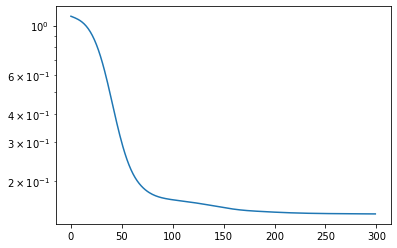

In [72]:
plt.plot(np.arange(0, step_num), accuracy_brute)
plt.yscale('log')

In [147]:
# now we try to estimate the gradient with classical shadows
#generate a random tensor list
bond_dim = 50
tensor_liste_rand = [pt.rand([1, 2, bond_dim], dtype=pt.cdouble)]
for idx in range(qubit_num - 2):
    tensor_liste_rand.append(pt.rand([bond_dim, 2, bond_dim], dtype=pt.cdouble))
tensor_liste_rand.append(pt.rand([bond_dim, 2, 1], dtype=pt.cdouble))
mps = MPS.from_tensor_list(tensor_liste_rand).normalise()
mps.canonicalise(qubit_num - 1)
param_vec = mps.to_param_vec()
# we only needed this param vec to determine the size of the tensor
random_param_vec = pt.rand(param_vec.shape[0], dtype=pt.cdouble)

In [148]:
# doing gradient descent using shadows
step_num = 200
lr = 0.01
num_of_measurements = 2
num_of_measurements_per_rot = np.array([5, 50, 500, 5000])
meas_method = 'derandomized'
num_unique_ind_shadow = np.zeros((2, np.size(num_of_measurements_per_rot), step_num))
accuracy = np.zeros((np.size(num_of_measurements_per_rot), step_num))
for num in range(np.size(num_of_measurements_per_rot)):
    random_param_vec_shadow = random_param_vec.clone().detach()
    random_param_vec_shadow.requires_grad_(True)
    opt = pt.optim.Adam([random_param_vec_shadow], lr=lr)
    print('starting meas_num ' + str(num_of_measurements_per_rot[num]))
    for i in range(step_num):
        opt.zero_grad()
        mps.from_param_vec(param_vec=random_param_vec_shadow)
        mps.normalise()
        with pt.no_grad():
            observables = TfimHamiltonianOpenFermion(qubit_num, ratio_h_j, 1, 'open').observables_for_energy_estimation()
            meas_outcomes, meas_procedure, probs = MPSQuantumState(qubit_num, mps).measurement_shadow(num_of_measurements, num_of_measurements_per_rot[num], meas_method, observables)
            num_unique_ind_shadow[0, num, i] = len(meas_outcomes[0])
            num_unique_ind_shadow[1, num, i] = len(meas_outcomes[1])
        energies = pt.zeros(len(meas_outcomes))
        for n in range(len(meas_outcomes)):
            probs_direct = MPSQuantumState(qubit_num, mps).rotate_pauli(meas_procedure[n]).prob(pt.tensor(meas_outcomes[n]))
            measurements = conversion_to_prediction_shadow_dict_shape([meas_procedure[n]]*len(meas_outcomes[n]), np.array(meas_outcomes[n]), qubit_num)
            energies[n] = TfimHamiltonianOpenFermion(qubit_num, ratio_h_j, 1, 'open').energy_shadow_mps_modified(measurements, probs_direct, meas_method)
        energy_shadow = pt.mean(energies)
        energy_shadow.backward()
        accuracy[num, i] = np.abs(energy_shadow.detach() - energy_brute) / np.abs(energy_brute)
        opt.step()
        print('progress: ' + str(i+1) + ' / ' + str(step_num))
        print(f'loss = {accuracy[num, i]}')

starting meas_num 5
progress: 1 / 200
loss = 0.9623054265975952
progress: 2 / 200
loss = 1.0289069414138794
progress: 3 / 200
loss = 0.9354187846183777
progress: 4 / 200
loss = 0.8713597059249878
progress: 5 / 200
loss = 0.8455864787101746
progress: 6 / 200
loss = 1.3598086833953857
progress: 7 / 200
loss = 1.136590600013733
progress: 8 / 200
loss = 1.2759383916854858
progress: 9 / 200
loss = 0.8493058085441589
progress: 10 / 200
loss = 0.9310349225997925
progress: 11 / 200
loss = 1.1920130252838135
progress: 12 / 200
loss = 1.2330050468444824
progress: 13 / 200
loss = 0.8691321015357971
progress: 14 / 200
loss = 0.9463632106781006
progress: 15 / 200
loss = 0.7048883438110352
progress: 16 / 200
loss = 0.9639924764633179
progress: 17 / 200
loss = 0.9701493382453918
progress: 18 / 200
loss = 1.0861051082611084
progress: 19 / 200
loss = 0.8221076726913452
progress: 20 / 200
loss = 1.0114127397537231
progress: 21 / 200
loss = 0.4719008803367615
progress: 22 / 200
loss = 0.8820431232452393


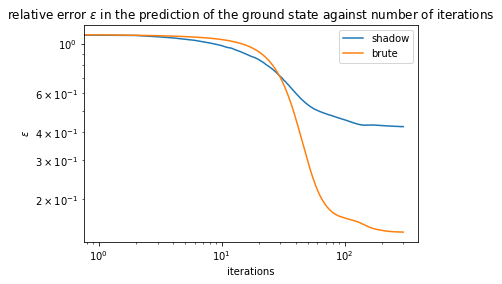

In [75]:
plt.plot(np.arange(0, step_num), accuracy, label='shadow')
plt.plot(np.arange(0, step_num), accuracy_brute, label='brute')
plt.title('relative error $\epsilon$ in the prediction of the ground state against number of iterations')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('iterations')
plt.ylabel('$\epsilon$')
plt.legend()

Third approach to obtain the gradient:
1.) Measure in the computational basis and obtain indices
2.) obtain the exact amplitudes of these indices
3.) fill these amplitudes/indices into a quantum state
4.) renormalize the quantum state
5.) determine the energy via contraction with Hamiltonian
6.) backpropagation

In [207]:
#generate a random tensor list
bond_dim = 50
tensor_liste_rand = [pt.rand([1, 2, bond_dim], dtype=pt.cdouble)]
for idx in range(qubit_num - 2):
    tensor_liste_rand.append(pt.rand([bond_dim, 2, bond_dim], dtype=pt.cdouble))
tensor_liste_rand.append(pt.rand([bond_dim, 2, 1], dtype=pt.cdouble))
mps = MPS.from_tensor_list(tensor_liste_rand).normalise()
mps.canonicalise(qubit_num - 1)
param_vec = mps.to_param_vec()
# we only needed this param vec to determine the size of the tensor
random_param_vec = pt.rand(param_vec.shape[0], dtype=pt.cdouble)

In [158]:
step_num = 1000
lr = 0.01
num_meas = np.array([100, 1000, 10000])
num_unique_ind_brute = np.zeros((np.size(num_meas),step_num))

accuracy_brute_sample = np.zeros((np.size(num_meas), step_num))
for num in range(np.size(num_meas)):
    random_param_vec_brute_sample = random_param_vec.clone().detach()
    random_param_vec_brute_sample.requires_grad_(True)
    opt = pt.optim.Adam([random_param_vec_brute_sample], lr=lr)
    for i in range(step_num):
        opt.zero_grad()
        mps.from_param_vec(param_vec = random_param_vec_brute_sample)
        mps.normalise()
        mps.canonicalise(qubit_num - 1)
        with pt.no_grad():
            indices, probs = MPSQuantumState(qubit_num, mps).measure(num_meas[num])
            num_unique_ind_brute[num, i] = len(indices)
        ampl_direct = MPSQuantumState(qubit_num, mps).amplitude(pt.tensor(indices))
        psi = pt.zeros(2**qubit_num, dtype=pt.cdouble)
        psi[indices] = ampl_direct
        psi = psi / pt.linalg.norm(psi)
        hamiltonian = pt.from_numpy(TfimHamiltonianOpenFermion(qubit_num, ratio_h_j, 1, 'open').to_matrix().todense())
        energy = psi.conj() @ hamiltonian @ psi
        energy.backward()
        accuracy_brute_sample[num, i] = np.abs(energy.detach() - energy_brute) / np.abs(energy_brute)
        opt.step()
        print('progress: ' + str(i+1) + ' / ' + str(step_num))

progress: 1 / 1000
progress: 2 / 1000
progress: 3 / 1000
progress: 4 / 1000
progress: 5 / 1000
progress: 6 / 1000
progress: 7 / 1000
progress: 8 / 1000
progress: 9 / 1000
progress: 10 / 1000
progress: 11 / 1000
progress: 12 / 1000
progress: 13 / 1000
progress: 14 / 1000
progress: 15 / 1000
progress: 16 / 1000
progress: 17 / 1000
progress: 18 / 1000
progress: 19 / 1000
progress: 20 / 1000
progress: 21 / 1000
progress: 22 / 1000
progress: 23 / 1000
progress: 24 / 1000
progress: 25 / 1000
progress: 26 / 1000
progress: 27 / 1000
progress: 28 / 1000
progress: 29 / 1000
progress: 30 / 1000
progress: 31 / 1000
progress: 32 / 1000
progress: 33 / 1000
progress: 34 / 1000
progress: 35 / 1000
progress: 36 / 1000
progress: 37 / 1000
progress: 38 / 1000
progress: 39 / 1000
progress: 40 / 1000
progress: 41 / 1000
progress: 42 / 1000
progress: 43 / 1000
progress: 44 / 1000
progress: 45 / 1000
progress: 46 / 1000
progress: 47 / 1000
progress: 48 / 1000
progress: 49 / 1000
progress: 50 / 1000
progress:

In [209]:
random_param_vec_brute_sample = random_param_vec.clone().detach()
random_param_vec_brute_sample.requires_grad_(True)
mps.from_param_vec(param_vec = random_param_vec_brute_sample)
mps.normalise()
mps.canonicalise(qubit_num - 1)
num_meas = 10000
indices, probs = MPSQuantumState(qubit_num, mps).measure(num_meas)
print(len(indices))
ampl_direct = MPSQuantumState(qubit_num, mps).amplitude(pt.tensor(indices))
psi = pt.zeros(2**qubit_num, dtype=pt.cdouble)
psi[indices] = ampl_direct
print(pt.linalg.norm(psi))
psi = psi / pt.linalg.norm(psi)
hamiltonian = pt.from_numpy(TfimHamiltonianOpenFermion(qubit_num, ratio_h_j, 1, 'open').to_matrix().todense())
energy = psi.conj() @ hamiltonian @ psi
energy.backward()
print(energy)
print(random_param_vec_brute_sample.grad)

31
tensor(0.0461, dtype=torch.float64, grad_fn=<CopyBackwards>)
tensor(7.1719+4.1633e-16j, dtype=torch.complex128, grad_fn=<DotBackward0>)
tensor([ 0.0451+0.0113j,  0.0357+0.0242j,  0.0266-0.0695j,  ...,
        -0.0314-0.0268j,  0.0273+0.0272j, -0.0301-0.0237j],
       dtype=torch.complex128)


In [205]:
ratio_h_j = 0.1
qubit_num = 14
save_direc_groundstate = Path('data/Diagonal_hamiltonian/groundstate_dict.npy')
ground_state_dict = np.load(save_direc_groundstate, allow_pickle='TRUE')
ground_state_dict = ground_state_dict.item()
ground_state = ground_state_dict[str(1)]['open'][str(qubit_num)][str(ratio_h_j)]
ground_state.requires_grad_(True)
mps = MPS.from_state_vector(qubit_num, ground_state)
mps.normalise()
mps.canonicalise(qubit_num - 1)
num_meas = 1000
indices, probs = MPSQuantumState(qubit_num, mps).measure(num_meas)
ampl_direct = MPSQuantumState(qubit_num, mps).amplitude(pt.tensor(indices))
psi = pt.zeros(2**qubit_num, dtype=pt.cdouble)
psi[indices] = ampl_direct
print(pt.linalg.norm(psi))
psi = psi / pt.linalg.norm(psi)
hamiltonian = pt.from_numpy(TfimHamiltonianOpenFermion(qubit_num, ratio_h_j, 1, 'open').to_matrix().todense())
energy = psi.conj() @ hamiltonian @ psi
energy.backward()
print(energy)
print(ground_state.grad)

tensor(0.9968, dtype=torch.float64, grad_fn=<CopyBackwards>)
tensor(-13.0162-4.3151e-17j, dtype=torch.complex128, grad_fn=<DotBackward0>)
tensor([ 3.3950e-02-6.4036e-02j, -1.2015e-02-5.5019e-02j,
         2.8780e-01+3.2607e-01j,  ...,
         1.5618e-16-1.6071e-16j, -1.9047e-16+1.4744e-17j,
         1.2225e-16-1.1967e-16j], dtype=torch.complex128)


In [199]:
random_param_vec_brute = random_param_vec.clone().detach()
random_param_vec_brute.requires_grad_(True)
mps.from_param_vec(param_vec = random_param_vec_brute)
psi = mps.to_state_vector()
hamiltonian = pt.from_numpy(TfimHamiltonianOpenFermion(qubit_num, ratio_h_j, 1, 'open').to_matrix().todense())
energy = psi.conj() @ hamiltonian @ psi / (psi.conj() @ psi)
energy.backward()
print(energy)
print(random_param_vec_brute.grad)

tensor(1.4148-1.0486e-16j, dtype=torch.complex128, grad_fn=<DivBackward0>)
tensor([-0.0889-2.5637e-02j, -0.1261+8.8463e-03j,  0.0076+6.2244e-02j,
         ...,  0.0006-5.2124e-05j, -0.0006+4.7724e-04j,
         0.0010-6.5946e-04j], dtype=torch.complex128)


In [168]:
step_num = 300
lr = 0.01
random_param_vec_brute_sample = random_param_vec.clone().detach()
random_param_vec_brute_sample.requires_grad_(True)
opt = pt.optim.Adam([random_param_vec_brute_sample], lr=lr)
num_meas = 10000

accuracy_brute_sample = np.zeros(step_num)
for i in range(0, step_num):
    opt.zero_grad()
    mps.from_param_vec(param_vec = random_param_vec_brute_sample)
    mps.normalise()
    mps.canonicalise(qubit_num - 1)
    with pt.no_grad():
        indices, probs = MPSQuantumState(qubit_num, mps).measure(num_meas)
    ampl_direct = MPSQuantumState(qubit_num, mps).amplitude(pt.tensor(indices))
    psi = pt.zeros(2**qubit_num, dtype=pt.cdouble)
    psi[indices] = ampl_direct
    psi = psi / pt.linalg.norm(psi)
    hamiltonian = pt.from_numpy(TfimHamiltonianOpenFermion(qubit_num, ratio_h_j, 1, 'open').to_matrix().todense())
    energy = psi.conj() @ hamiltonian @ psi
    energy.backward()
    accuracy_brute_sample[i] = np.abs(energy.detach() - energy_brute) / np.abs(energy_brute)
    opt.step()
    print('progress: ' + str(i+1) + ' / ' + str(step_num))

progress: 1 / 150
progress: 2 / 150
progress: 3 / 150
progress: 4 / 150
progress: 5 / 150
progress: 6 / 150
progress: 7 / 150
progress: 8 / 150
progress: 9 / 150
progress: 10 / 150
progress: 11 / 150
progress: 12 / 150
progress: 13 / 150
progress: 14 / 150
progress: 15 / 150
progress: 16 / 150
progress: 17 / 150
progress: 18 / 150
progress: 19 / 150
progress: 20 / 150
progress: 21 / 150
progress: 22 / 150
progress: 23 / 150
progress: 24 / 150
progress: 25 / 150
progress: 26 / 150
progress: 27 / 150
progress: 28 / 150
progress: 29 / 150
progress: 30 / 150
progress: 31 / 150
progress: 32 / 150
progress: 33 / 150
progress: 34 / 150
progress: 35 / 150
progress: 36 / 150
progress: 37 / 150
progress: 38 / 150
progress: 39 / 150
progress: 40 / 150
progress: 41 / 150
progress: 42 / 150
progress: 43 / 150
progress: 44 / 150
progress: 45 / 150
progress: 46 / 150
progress: 47 / 150
progress: 48 / 150
progress: 49 / 150
progress: 50 / 150
progress: 51 / 150
progress: 52 / 150
progress: 53 / 150
pr

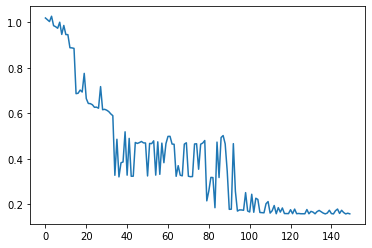

In [169]:
plt.plot(np.arange(0, step_num), accuracy_brute_sample, label='brute sample')

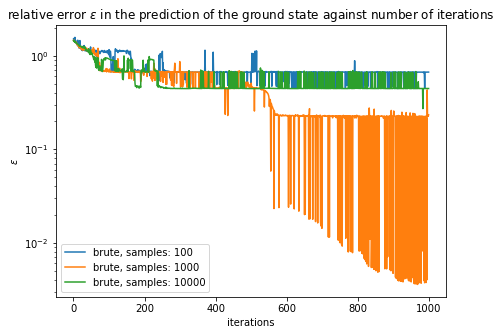

In [159]:
plt.figure(figsize=(7,5))
for num in range(np.size(num_meas)):
    plt.plot(np.arange(0, step_num), accuracy_brute_sample[num, :], label='brute, samples: ' + str(num_meas[num]))
    #plt.plot(np.arange(0, step_num), accuracy[num, :], label='shadow, samples: ' + str(num_meas[num]))
#plt.plot(np.arange(0, step_num), accuracy_brute, label='brute')
plt.title('relative error $\epsilon$ in the prediction of the ground state against number of iterations')
plt.yscale('log')
plt.xlabel('iterations')
plt.ylabel('$\epsilon$')
plt.legend()

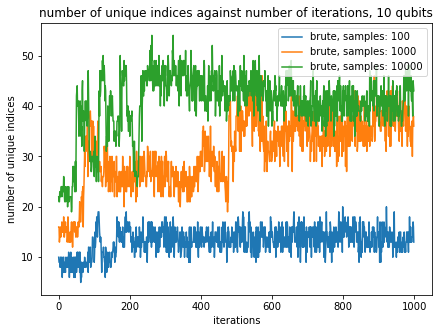

In [160]:
plt.figure(figsize=(7,5))
for num in range(np.size(num_meas)):
    plt.plot(np.arange(0, step_num), num_unique_ind_brute[num, :], label='brute, samples: ' + str(num_meas[num]))
    #plt.plot(np.arange(0, step_num), num_unique_ind_shadow[0, num, :], label='shadow X, samples: ' + str(num_meas[num]))
    #plt.plot(np.arange(0, step_num), num_unique_ind_shadow[1, num, :], label='shadow Z, samples: ' + str(num_meas[num]))
plt.xlabel('iterations')
plt.ylabel('number of unique indices')
plt.title('number of unique indices against number of iterations, ' + str(qubit_num) + ' qubits')
#plt.yscale('log')

plt.legend()